In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

 ## Define the file path here

In [3]:
folder_path = ""
file_title = "fine-grained-data ___boundaryMean0.35___boundarySD0.2___OpinionMean0___OpinionSD0.2___OpinionDistributionnormal___NetworkTypeScale-free___RS1___MediaOpinions[-0.9 -0.7 0 0.7 0.9]"
file_name = file_title + ".csv"
file_path = os.path.join(folder_path, file_name)


In [4]:
# print("Current working directory:", os.getcwd())


use_media = True

 ## Reading metadata then the data
 

In [6]:
from io import StringIO

# Read the entire file
with open(file_path, 'r') as file:
    lines = file.readlines()

separator = "-----------------"
sep_indices = [i for i, line in enumerate(lines) if separator in line]

# Step 1: Extract metadata (before first separator)
metadata_lines = lines[:sep_indices[0]]
metadata_df = pd.read_csv(StringIO(''.join(metadata_lines)), header=None)
metadata_dict = dict(zip(metadata_df[0], metadata_df[1]))

# Step 2: Identify where the main CSV data starts (after last separator)
data_start_index = sep_indices[-1] + 1
data_lines = lines[data_start_index:]

# Step 3: Convert data_lines into a file-like object for pandas
from io import StringIO
data_csv = StringIO("".join(data_lines))

# Step 4: Read it into a dataframe
df = pd.read_csv(data_csv)

# Check
print("✅ Metadata dictionary:\n", metadata_dict)
print("\n✅ Main dataframe columns:\n", df.columns)
print("\n✅ First few rows of data:\n", df.head())

✅ Metadata dictionary:
 {'random-seed': '1', 'conformity-mean': '0.2', 'conformity-sd': '0', 'conformity-distribution': 'normal', 'HK-distribution': 'false', 'N': '966', 'boundary-mean': '0.35', 'boundary-sd': '0.2', 'boundary-distribution': 'normal', 'SPIRO-mean': '1', 'SPIRO-sd': '0', 'SPIRO-distribution': 'covert', 'Identity-Type': 'global', 'Identity-Levels': '7', 'Use_Identity?': 'false', 'Media-House-Positions': '[-0.9 -0.7 0 0.7 0.9]'}

✅ Main dataframe columns:
 Index(['timeStep', ' agentID', ' opinion', ' previousOpinion', ' boundary',
       ' conformity', ' SPIRO', ' groupNumber', ' Influencer ID's'],
      dtype='object')

✅ First few rows of data:
    timeStep   agentID                 opinion  previousOpinion   boundary  \
0         0       509                [-0.379]         [-0.379]      0.115   
1         0       256               [-0.0022]         [-0.001]      0.535   
2         0       204   [0.16419999999999998]          [0.207]      0.553   
3         0       806 

 ## Some needed cleanup

In [8]:
# To remove accidental spaces before the column name
df.columns = df.columns.str.strip()
if(use_media == True):
    # Clean 'Media-House-Positions' in metadata_dict
    media_str = metadata_dict.get('Media-House-Positions', '')  # get the string from metadata
    media_str = media_str.strip('[]')  # remove brackets
    media_positions = [float(x) for x in media_str.split()]  # convert to list of floats

# 'opinion' and 'previousOpinion' have leading and ending brackets and need to be converted to numerics
df['opinion'] = pd.to_numeric(df['opinion'].str.strip("[]"))
df['previousOpinion'] = pd.to_numeric(df['previousOpinion'].str.strip("[]"))

# Remove brackets and convert space-separated string into list of ints
df["influencerIDs"] = df["Influencer ID's"].str.strip("[]").apply(lambda x: [int(i) for i in x.split()])

In [9]:
print(df)
print(media_positions)

        timeStep  agentID       opinion  previousOpinion  boundary  \
0              0      509 -3.790000e-01    -3.790000e-01     0.115   
1              0      256 -2.200000e-03    -1.000000e-03     0.535   
2              0      204  1.642000e-01     2.070000e-01     0.553   
3              0      806  7.600000e-03     9.000000e-03     0.417   
4              0      512  9.920000e-02     1.330000e-01     0.160   
...          ...      ...           ...              ...       ...   
352563       364      335  9.500000e-02     9.500000e-02     0.255   
352564       364      928 -1.900000e-02    -1.900000e-02     0.256   
352565       364      313  4.816709e-36     6.020886e-36     0.689   
352566       364      954 -2.000000e-03    -2.000000e-03     0.262   
352567       364      118  1.000000e-02     1.000000e-02     0.037   

        conformity  SPIRO  groupNumber  \
0              0.2      1         1070   
1              0.2      1         1070   
2              0.2      1        

## Opinion Plot

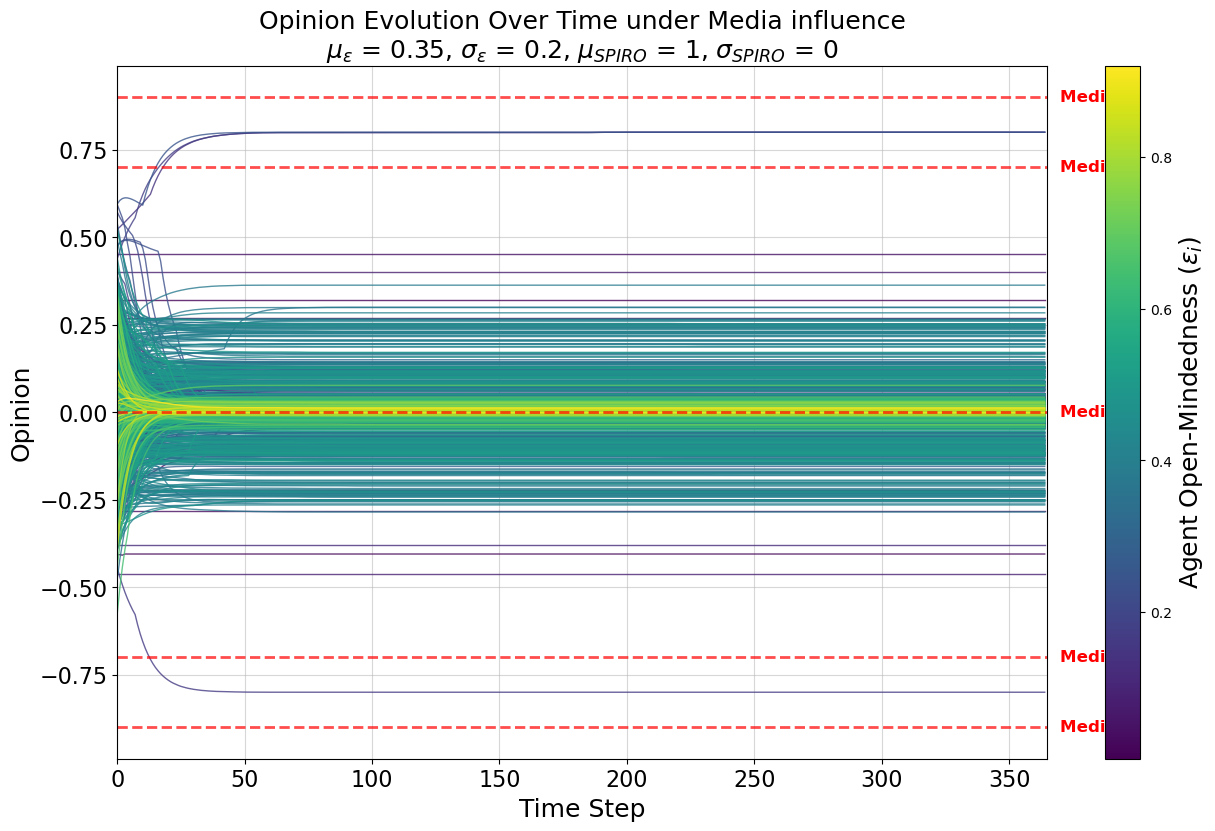

In [11]:
thickness_by_SPIRO = False

# Extract metadata values
mu_epsilon = metadata_dict["boundary-mean"]  # Mean boundary
sigma_epsilon = metadata_dict["boundary-sd"]  # Std boundary
mu_SPIRO = metadata_dict["SPIRO-mean"]  # Mean SPIRO
sigma_SPIRO = metadata_dict["SPIRO-sd"]  # Std SPIRO


# Normalize boundary values to a colormap range (0 to 1)
norm = plt.Normalize(df["boundary"].min(), df["boundary"].max())
cmap = plt.cm.viridis  # Choose colormap
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)  # Create color mapping

# Sort agents by boundary in ascending order
sorted_agents = df.groupby("agentID").first().sort_values(by="boundary").index

# Create the plot
fig, ax = plt.subplots(figsize=(15, 9))

# Loop through each agent in sorted order (low boundary first, high boundary last)
for agent_id in sorted_agents:
    agent_data = df[df["agentID"] == agent_id]
    
    if(thickness_by_SPIRO):
        linewidth = 1.5 + 2*(0.25 - agent_data["SPIRO"].iloc[0])
    else:
        linewidth = 1 # Haardcoding it away from potentially problematic SPIRO values.
    
    color = cmap(norm(agent_data["boundary"].iloc[0]))  # Pick color based on first boundary value
    ax.plot(agent_data["timeStep"], agent_data["opinion"], color=color, alpha=0.8, linewidth=linewidth)

if(use_media):
    # Plot horizontal lines for media opinions
    for i, media_opinion in enumerate(media_positions):
        ax.axhline(y=media_opinion, color='red', linestyle='--', linewidth=2, alpha=0.7)
        ax.text(
            x=370,  # Just outside the x-limit for a neat label
            y=media_opinion,
            s=f"Media {i+1}",
            color='red',
            va='center',
            fontsize=12,
            fontweight='bold'
        )

# Add colorbar
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Agent Open-Mindedness ($\\epsilon_{i}$)", fontsize = 18)

# Labels and title
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim([0, 365])
ax.set_xlabel("Time Step", fontsize = 18)
ax.set_ylabel(f"Opinion", fontsize = 18)
# LaTeX formatted title with subscripts
ax.set_title(
    f"Opinion Evolution Over Time under Media influence\n"
    f"$\\mu_\\epsilon$ = {mu_epsilon}, $\\sigma_\\epsilon$ = {sigma_epsilon}, "
    f"$\\mu_{{SPIRO}}$ = {mu_SPIRO}, $\\sigma_{{SPIRO}}$ = {sigma_SPIRO}", fontsize = 18
)
ax.grid(True, linestyle="-", alpha=0.5)

            
this_figure_path = os.path.join(folder_path, file_title + ".png")
plt.savefig(this_figure_path, dpi=200, bbox_inches='tight')

# Show the plot
plt.show()


In [12]:
# from PIL import Image
# import glob

# # Create and save individual frames
# for t in np.arange(365):
#     plt.figure(figsize=(10, 6))
#     t_data = df[df["timeStep"] == t]
#     plt.hist(t_data["opinion"], bins=200, range=(-1, 6))
#     plt.xlim(-1, 1)
#     plt.ylim(0, 550)
#     plt.title(f'Time Step: {t}')
#     plt.savefig(f'temp/frame_{t:03d}.png')
#     plt.close()

# # Combine into GIF (requires ImageMagick)
# frames = [Image.open(img) for img in sorted(glob.glob("temp/frame_*.png"))]
# frames[0].save('opinion_evolution.gif',
#                format='GIF',
#                append_images=frames[1:],
#                save_all=True,
#                duration=150,  # ms per frame
#                loop=0)

ShapiroResult(statistic=0.9967221617698669, pvalue=0.042893681675195694)


<Figure size 1000x600 with 0 Axes>

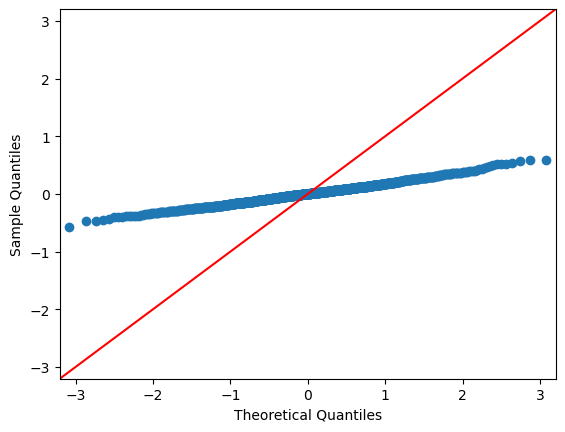

ShapiroResult(statistic=0.995287299156189, pvalue=0.004449900705367327)


<Figure size 1000x600 with 0 Axes>

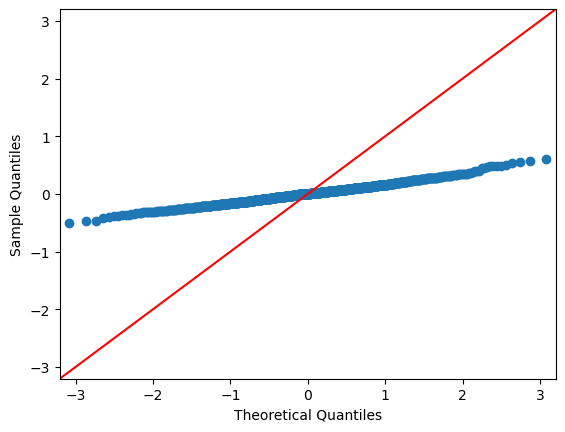

ShapiroResult(statistic=0.9930939674377441, pvalue=0.0001848122337833047)


<Figure size 1000x600 with 0 Axes>

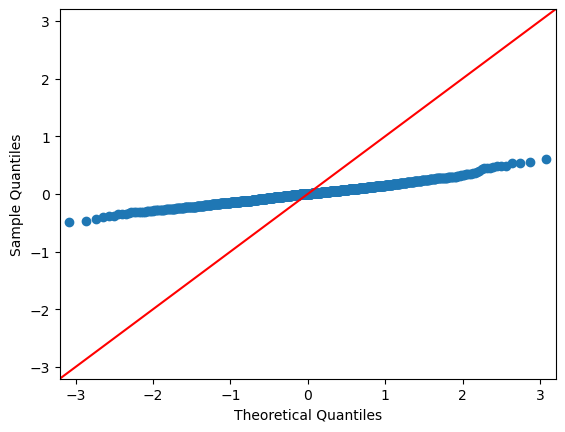

ShapiroResult(statistic=0.9901237487792969, pvalue=4.383637133287266e-06)


<Figure size 1000x600 with 0 Axes>

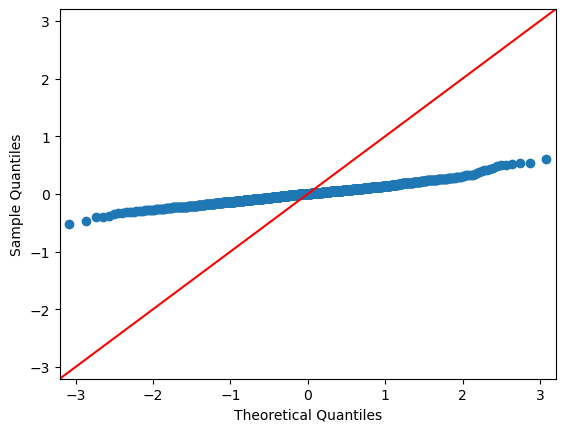

ShapiroResult(statistic=0.9861329197883606, pvalue=6.292057008749907e-08)


<Figure size 1000x600 with 0 Axes>

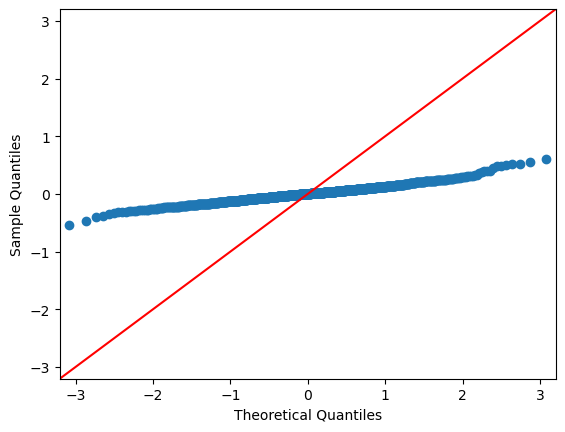

ShapiroResult(statistic=0.9806877374649048, pvalue=5.175802009205199e-10)


<Figure size 1000x600 with 0 Axes>

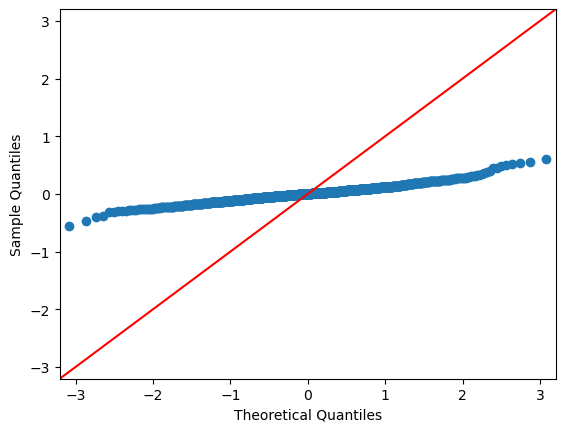

ShapiroResult(statistic=0.9743294715881348, pvalue=4.958909151364654e-12)


<Figure size 1000x600 with 0 Axes>

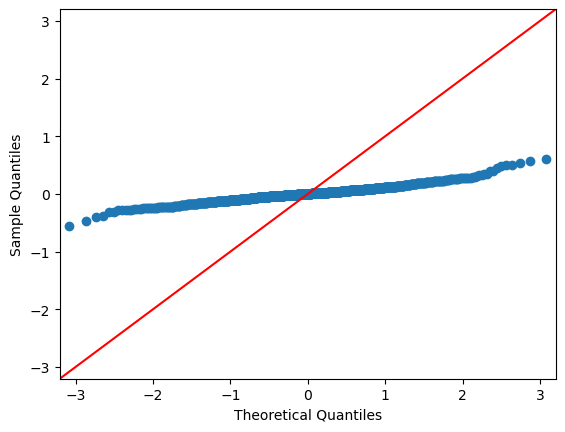

ShapiroResult(statistic=0.9672396779060364, pvalue=6.278322046276985e-14)


<Figure size 1000x600 with 0 Axes>

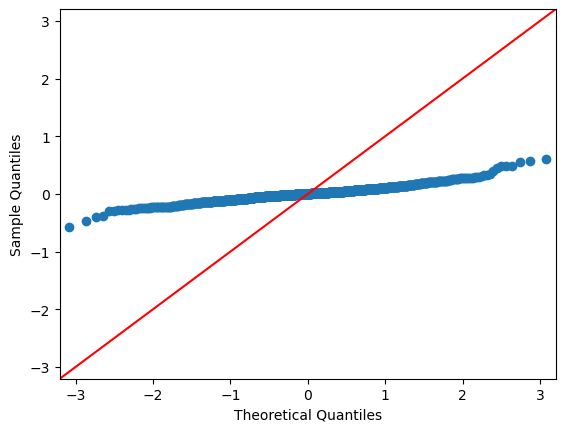

ShapiroResult(statistic=0.9587168097496033, pvalue=7.164119964582147e-16)


<Figure size 1000x600 with 0 Axes>

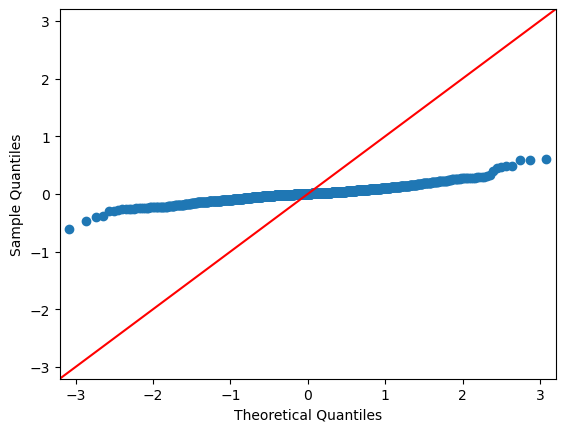

ShapiroResult(statistic=0.9500811696052551, pvalue=1.427945182401918e-17)


<Figure size 1000x600 with 0 Axes>

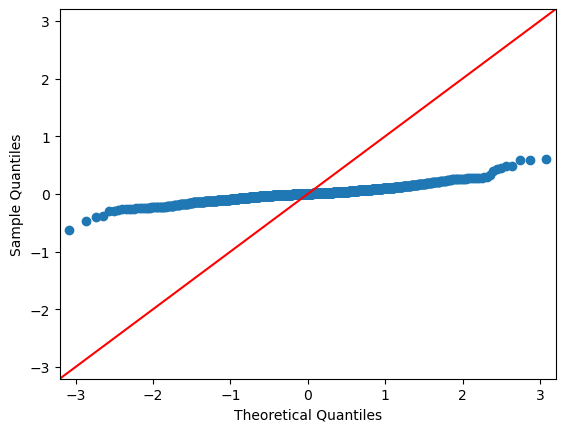

ShapiroResult(statistic=0.9418641328811646, pvalue=5.2737902909811e-19)


<Figure size 1000x600 with 0 Axes>

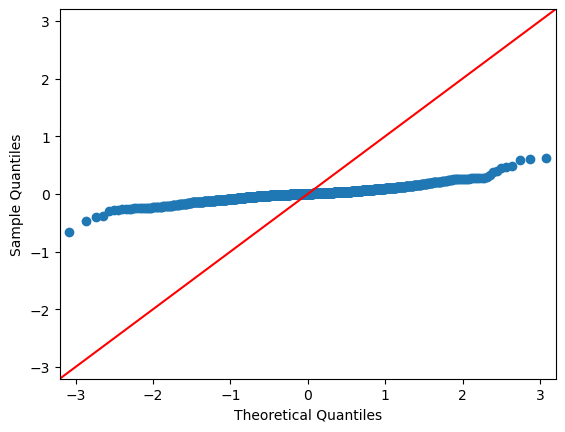

ShapiroResult(statistic=0.9326493144035339, pvalue=1.9103812179507467e-20)


<Figure size 1000x600 with 0 Axes>

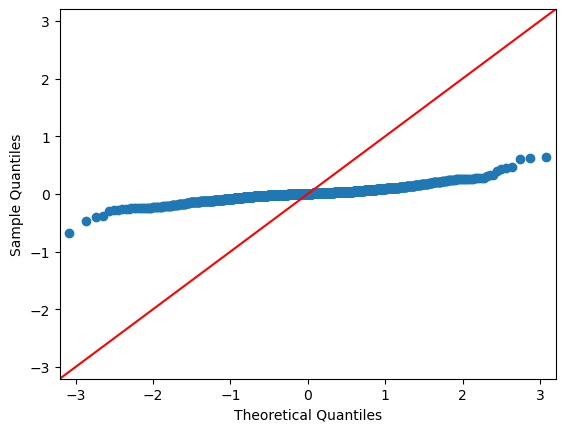

ShapiroResult(statistic=0.923930287361145, pvalue=1.111314628610096e-21)


<Figure size 1000x600 with 0 Axes>

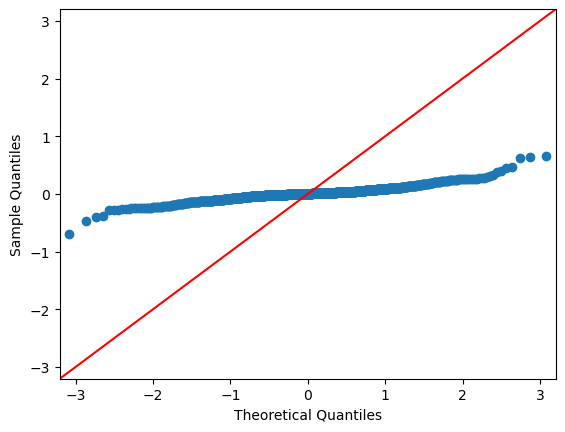

ShapiroResult(statistic=0.9152672290802002, pvalue=8.296739809933778e-23)


<Figure size 1000x600 with 0 Axes>

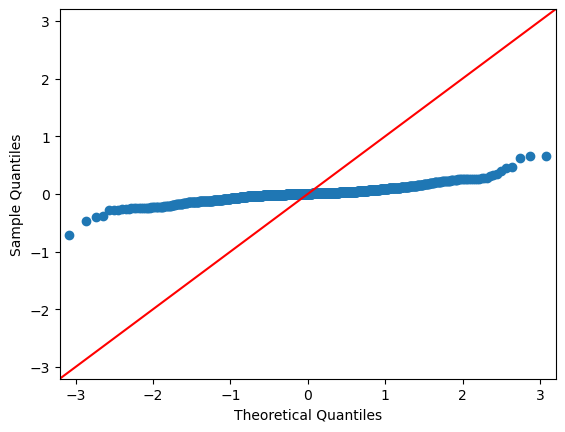

ShapiroResult(statistic=0.9065462350845337, pvalue=7.392353222814589e-24)


<Figure size 1000x600 with 0 Axes>

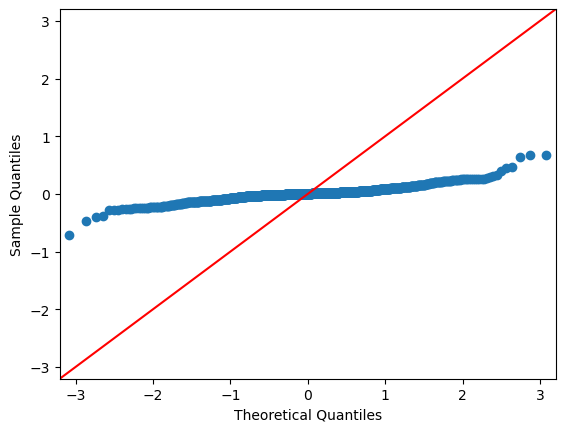

ShapiroResult(statistic=0.898378849029541, pvalue=8.925324137394783e-25)


<Figure size 1000x600 with 0 Axes>

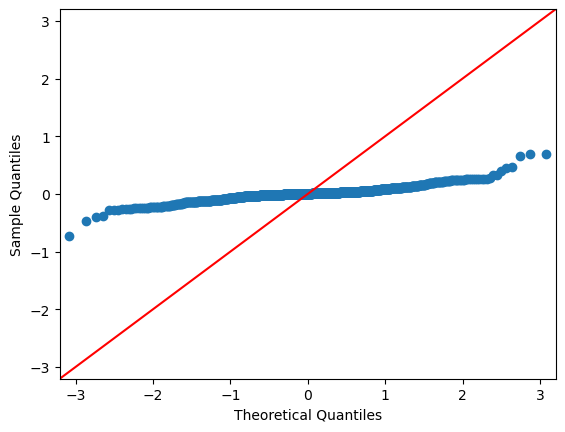

ShapiroResult(statistic=0.8908346891403198, pvalue=1.4165386687993555e-25)


<Figure size 1000x600 with 0 Axes>

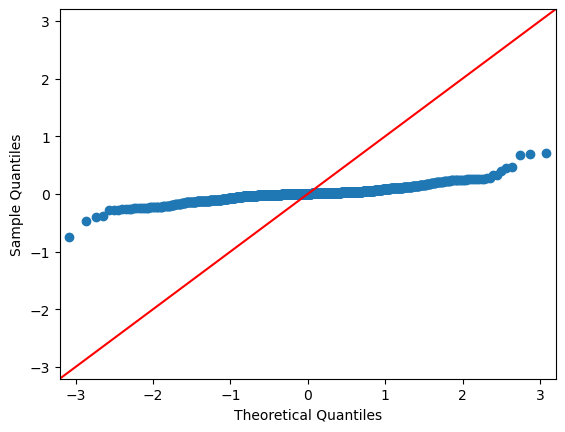

ShapiroResult(statistic=0.8846650719642639, pvalue=3.375630106970787e-26)


<Figure size 1000x600 with 0 Axes>

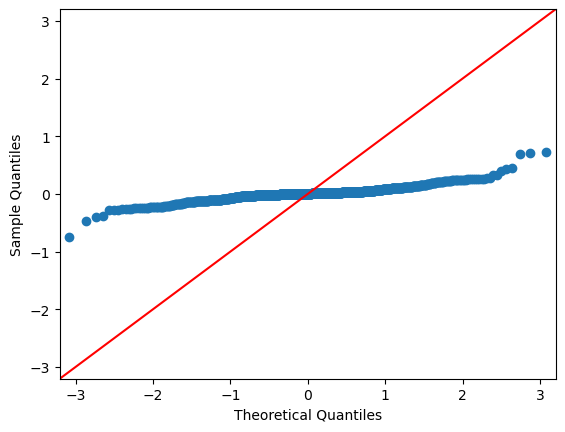

ShapiroResult(statistic=0.8793278336524963, pvalue=1.0229997522712657e-26)


<Figure size 1000x600 with 0 Axes>

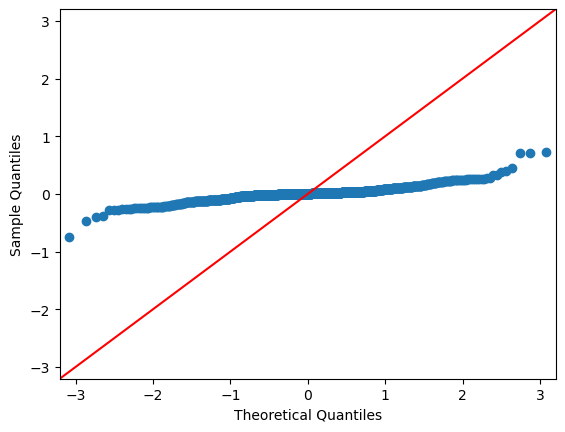

ShapiroResult(statistic=0.8744398355484009, pvalue=3.550725719715961e-27)


<Figure size 1000x600 with 0 Axes>

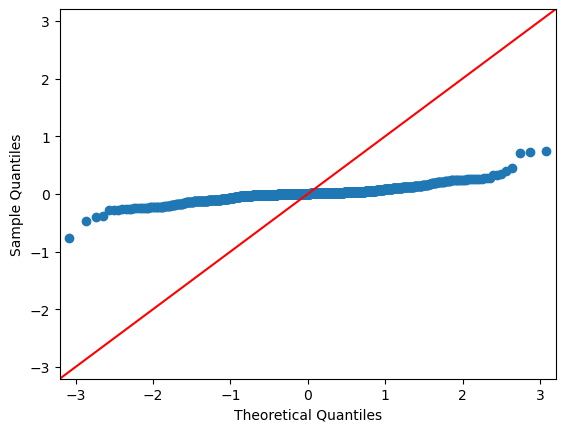

In [13]:
# Testing Normality


from scipy.stats import lognorm
import statsmodels.api as sm
from scipy.stats import shapiro 

for t in np.arange(0, 20):

    plt.figure(figsize=(10, 6))
    t_data = df[df["timeStep"] == t]

    #create Q-Q plot with 45-degree line added to plot
    fig = sm.qqplot(t_data["opinion"], line='45')
    print(shapiro(t_data["opinion"]))

    

    plt.show()

## Seeing Group Structure evolve


In [15]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # ----- First Plot: Number of Unique Groups Over Time -----
# unique_groups_per_time = df.groupby("timeStep")["groupNumber"].nunique()

# # ----- Second Plot: Fraction of Agents in Groups Over Time -----
# # Step 1: Count agents in each group at each time step
# agents_per_group = df.groupby(["timeStep", "groupNumber"])["agentID"].count()

# # Step 2: Compute total agents per time step
# total_agents_per_time = agents_per_group.groupby("timeStep").sum()

# # Step 3: Convert counts to fractions by dividing each group count by the total agents at that time step
# agents_fraction_per_group = agents_per_group.div(total_agents_per_time, level="timeStep")

# # Step 4: Pivot table to get a wide format (timeStep as rows, group sizes as columns)
# fraction_per_time_wide = agents_fraction_per_group.unstack(fill_value=0)

# # Step 5: Sort each row’s values in descending order (largest groups first)
# sorted_fractions = fraction_per_time_wide.apply(lambda x: sorted(x, reverse=True), axis=1, result_type="expand")

# # ----- Create the Figure with Two Subplots -----
# fig, ax = plt.subplots(figsize=(15, 9))


# # # Second subplot: Stacked Bar Chart of Group Fractions Over Time
# sorted_fractions.plot(kind="bar", stacked=True, ax=axes[1], width=1, cmap="viridis", alpha=0.8)

# # # Formatting for second plot
# # axes[1].set_xlabel("Time Step", fontsize=14)
# # axes[1].set_ylabel("Fraction of Agents", fontsize=14)
# # axes[1].grid(axis="y", linestyle="--", alpha=0.5)
# # axes[1].legend_.remove()  # Hide legend since group numbers aren't meaningful

# # Adjust layout
# plt.tight_layout()
# plt.show()


## Media Houses.